A lot of the code is from here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Imports

In [103]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

In [14]:
%cd ./utils/
from dataloaders import CocoNoCropping
from config import CATEGORIES_OF_INTEREST; print(CATEGORIES_OF_INTEREST)
# help(CocoNoCropping) # should not be blank
%cd ..

/Users/gbatch/Documents/projects/current/cocoapi/PythonAPI/utils
['bird', 'cat', 'dog', 'person']
/Users/gbatch/Documents/projects/current/cocoapi/PythonAPI


# Transforms, Datasets, and Data Loaders

In [3]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train1': transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'dev': transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = 'data/hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

In [92]:
train_transforms = torch.nn.Sequential(
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(), # simple augmentation
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

dev_transforms = torch.nn.Sequential(
    transforms.Resize(size=(224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

In [93]:
train1_dataset = CocoNoCropping(
    img_ids = '../my_splits/train1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../images/train2017/',
    transform=simple_transforms,
    divide_by_255=True
)

dev1_dataset = CocoNoCropping(
    img_ids = '../my_splits/dev1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../images/train2017/',
    transform=simple_transforms,
    divide_by_255=True
)

In [94]:
train1_dataloader = DataLoader(train1_dataset, batch_size=8, shuffle=True, drop_last=True)
dev1_dataloader = DataLoader(dev1_dataset, batch_size=8, shuffle=True, drop_last=True)

# Visualize a few images

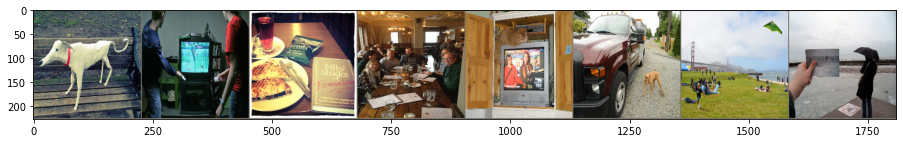

,0,1,2,3,4,5,6,7
bird,0,0,0,0,0,0,0,1
cat,0,0,0,0,1,0,0,0
dog,1,0,0,0,0,1,0,0
person,0,1,0,1,1,0,1,1


In [95]:
fig, ax = plt.subplots(figsize=(18, 2))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    # ImageNet constants
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
batch = next(iter(train1_dataloader))
inputs, labels = batch['image'], batch['label']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

pd.DataFrame({CATEGORIES_OF_INTEREST[i]: labels[i].numpy() for i in range(len(labels))}).T

# Training and Validation Loops

In [96]:
def train_one_epoch(iterator, model, criterion, optimizer):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in iterator:
        model.train()

        inputs = batch['image'] # [batch size, channel, h, w]
        #print(inputs.shape, inputs.dtype)
        # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
        labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32)
        #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
        total += labels.shape[0] 
        
        optimizer.zero_grad()

        outputs = model(inputs) #logits
        #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
        #print(outputs)

        loss = criterion(outputs, labels)
        epoch_loss += loss.item() # no need to drag 
        #print(loss.item())

        loss.backward()
        optimizer_ft.step()

        preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
        #print(preds)
        per_class_correct += (preds == labels).sum(0) # 0-th axis for batch_size
        #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

In [97]:
def evaluate(iterator, model, criterion):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in iterator:
        
        # no need for gradients, batch-norm and dropout in evaluation mode
        model.eval()
        with torch.no_grad():
            
            inputs = batch['image'] # [batch size, channel, h, w]
            #print(inputs.shape, inputs.dtype)
            # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
            labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32)
            #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
            total += labels.shape[0] 

            outputs = model(inputs) #logits
            #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
            #print(outputs)

            loss = criterion(outputs, labels)
            epoch_loss += loss.item() # no need to drag 
            #print(loss.item())

            preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
            #print(preds)
            per_class_correct += (preds == labels).sum(0) # 0-th axis for batch_size
            #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

# Device, Model, Criterion, Optimizer

In [98]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [113]:
# load pre-trained model
model_ft = models.resnet18(pretrained=True)

# freese all parameters initially
for param in model_ft.parameters():
    param.requires_grad = False
    
# unfreeeze model parameters of the last layer
for param in model_ft.fc.parameters():
    param.requires_grad = True

# replace the last layer to fit the task
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, len(CATEGORIES_OF_INTEREST))

# place it on the device
model_ft = model_ft.to(device)

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [114]:
#model_ft

In [115]:
%%time

num_epochs = 5
train_epoch_loss_history = []
train_per_class_acc_history = []

dev_epoch_loss_history = []
dev_per_class_acc_history = []

best_acc = None
best_epoch = None

best_model_wts = copy.deepcopy(model_ft.state_dict())

for epoch in range(num_epochs):
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
 
        
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_per_class_acc.mean()
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    print()
    print('-'*80)
    print()

Train Avg Acc: 0.7265625
Train Loss: 2.5393458704153695
Train Accs per class: tensor([0.8229, 0.7708, 0.6771, 0.6354])

Dev Avg Acc: 0.7822580337524414
Dev Loss: 2.2076322849719756
Dev Accs per class: tensor([0.8266, 0.8468, 0.7702, 0.6855])

--------------------------------------------------------------------------------

Train Avg Acc: 0.7994791865348816
Train Loss: 2.0272092123826346
Train Accs per class: tensor([0.8854, 0.8021, 0.7917, 0.7188])

Dev Avg Acc: 0.7394153475761414
Dev Loss: 2.760760666862611
Dev Accs per class: tensor([0.8266, 0.7500, 0.7923, 0.5887])

--------------------------------------------------------------------------------

Train Avg Acc: 0.7630208134651184
Train Loss: 2.6979794005552926
Train Accs per class: tensor([0.8333, 0.6146, 0.8021, 0.8021])

Dev Avg Acc: 0.7661290168762207
Dev Loss: 3.0322764785059038
Dev Accs per class: tensor([0.8347, 0.8306, 0.7762, 0.6230])

--------------------------------------------------------------------------------

Train Av